In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../"))

from desc.objectives import (
    ObjectiveFunction,
    ForceBalance
)
from desc.basis import ZernikePolynomial, FourierZernikeBasis,FourierZernike_to_FourierZernike_no_N_modes,get_basis_poincare, DoubleFourierSeries
from desc.transform import Transform
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.plotting import plot_1d,plot_2d,plot_3d,plot_comparison, plot_section, plot_fsa, plot_surfaces
from desc.optimize import Optimizer
from desc.perturbations import *
import numpy as np
from desc.geometry import FourierRZToroidalSurface, ZernikeRZToroidalSection, PoincareSurface
%matplotlib inline
from desc.utils import copy_coeffs, print_modes_coefs
import matplotlib.pyplot as plt
from desc.examples import get
from desc.objectives.getters import get_fixed_boundary_constraints, maybe_add_self_consistency
from desc.grid import LinearGrid
import plotly.graph_objects as go

def get_poin_GS(eq):
    eq_poin = eq.set_poincare_equilibrium()
    eq_poin.change_resolution(eq.L,eq.M,eq.N) 
    surf=eq_poin.get_surface_at(rho=1)
    
    eq_GS = Equilibrium(
        surface=surf,
        pressure=eq_poin.pressure,
        iota=eq_poin.iota,
        Psi=eq_poin.Psi, # flux (in Webers) within the last closed flux surface
        NFP=eq_poin.NFP, # number of field periods
        L=eq_poin.L, # radial spectral resolution
        M=eq_poin.M, # poloidal spectral resolution
        N=0, # toroidal spectral resolution 
        L_grid=eq_poin.L_grid, # real space radial resolution, slightly oversampled
        M_grid=eq_poin.M_grid, # real space poloidal resolution, slightly oversampled
        N_grid=eq_poin.N_grid, # real space toroidal resolution
        sym=True, # explicitly enforce stellarator symmetry
        spectral_indexing=eq_poin._spectral_indexing,  
    )
    return eq_GS

def get_perturbed_GS_Poincare(eq, eq_GS, eq_poin, step, numstep):
    surface_Poincare = eq_poin.get_surface_at(zeta=0)
    surface_GS = eq_GS.get_surface_at(zeta=0)
    
    Rb_lmn = surface_GS.R_lmn + (surface_Poincare.R_lmn - surface_GS.R_lmn)*step/numstep
    Zb_lmn = surface_GS.Z_lmn + (surface_Poincare.Z_lmn - surface_GS.Z_lmn)*step/numstep
    
    Rb_basis = surface_GS.R_basis
    Zb_basis = surface_GS.Z_basis
    
    L_GS_lmn, L_GS_basis = FourierZernike_to_FourierZernike_no_N_modes(eq_GS.L_lmn, eq_GS.L_basis)
    L_GS_lmn, L_GS_basis = get_basis_poincare(L_GS_lmn, L_GS_basis)
    # print(f"{L_GS_lmn.size=}\n{L_GS_lmn=}")
    
    L_Poin_lmn, L_Poin_basis = FourierZernike_to_FourierZernike_no_N_modes(eq_poin.L_lmn, eq_poin.L_basis)
    L_Poin_lmn, L_Poin_basis = get_basis_poincare(L_Poin_lmn, L_Poin_basis)
    # print(f"{L_Poin_lmn.size=}\n{L_Poin_lmn=}")

    Lb_lmn = L_GS_lmn + (L_Poin_lmn - L_GS_lmn)*step/numstep

    surf = ZernikeRZToroidalSection(
        R_lmn=Rb_lmn,
        modes_R=Rb_basis.modes[:, :2].astype(int),
        Z_lmn=Zb_lmn,
        modes_Z=Zb_basis.modes[:, :2].astype(int),
        spectral_indexing=eq_poin._spectral_indexing,
    )
    
    surface = PoincareSurface(surface=surf, L_lmn=Lb_lmn, modes_L=L_GS_basis.modes)
    # print(f"{surface.L_lmn.size=}\n{surface.L_lmn=}")
    
    eq.surface = surface
    return eq

DESC version 0.10.4+122.g126d7a70.dirty,using JAX backend, jax version=0.4.14, jaxlib version=0.4.14, dtype=float64
Using device: CPU, with 10.70 GB available memory


### Get Heliotron and Construct Poincare, Grad-Shafranov Initial Guesses

In [2]:
eq = get("HELIOTRON")
eq_GS = get_poin_GS(eq)
eq_poin = eq.set_poincare_equilibrium()

### Solve Grad-Shafranov

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 4.21 sec
Timer: Objective build = 7.22 sec
Timer: Linear constraint projection build = 6.38 sec
Compiling objective function and derivatives: ['force']
Timer: Objective compilation time = 1.25 sec
Timer: Jacobian compilation time = 3.47 sec
Timer: Total compilation time = 4.73 sec
Number of parameters: 222
Number of objectives: 4940
Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          1.211e-02                                    9.684e+00   
       1              2          9.387e-03      2.720e-03      3.687e-01      9.813e+01   
       2              3          4.963e-04      8.891e-03      1.582e-01      1.946e+01   
       3              4          2.935e-04      2.028e-04      2.180e-01      2.719e+00   
       4              5          2.357e-04      5.771e-05      2.028e-01      2.4

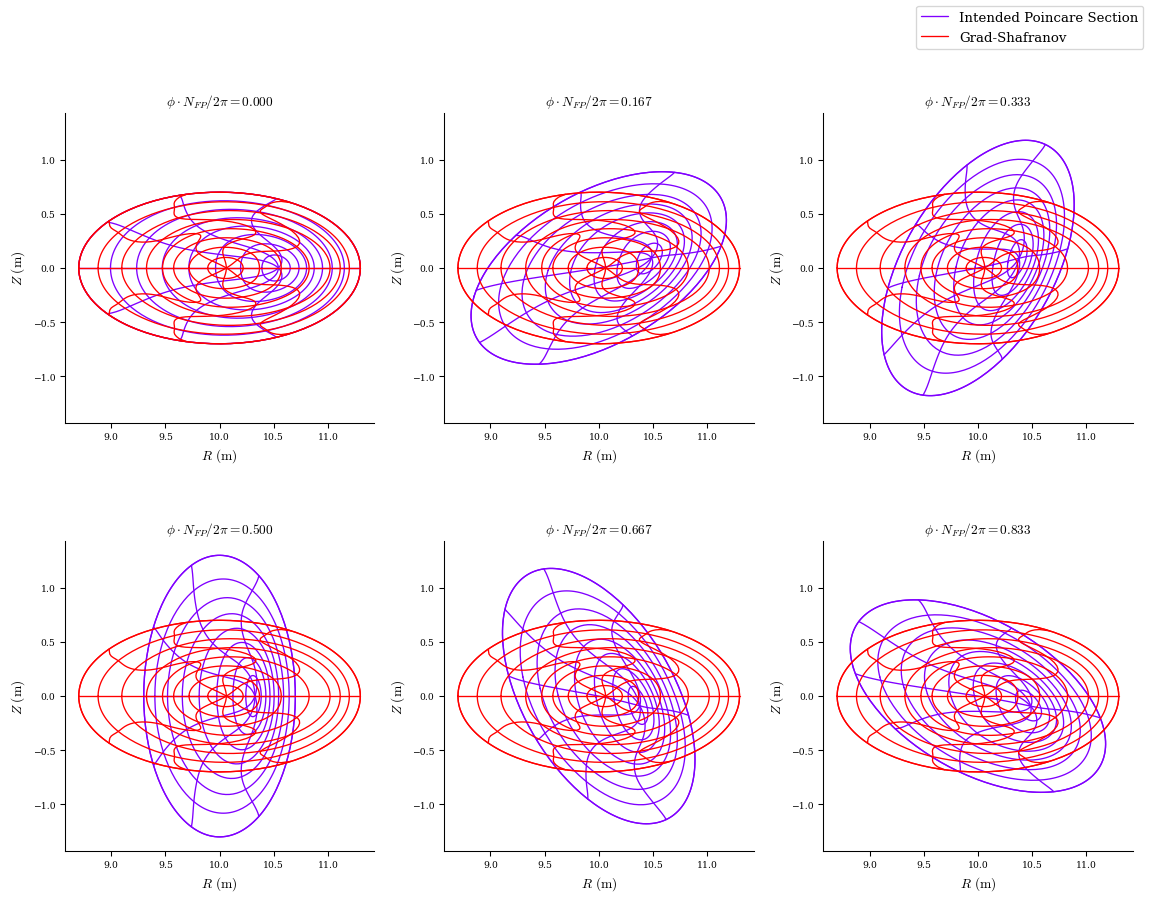

In [3]:
maxiter_GS = 20

constraints = get_fixed_boundary_constraints(eq=eq_GS)
objective = ObjectiveFunction(ForceBalance(eq_GS))
eq_GS.solve(verbose=3, objective=objective, constraints=constraints, maxiter=maxiter_GS, ftol=0, xtol=0, gtol=0)
plot_comparison(eqs=[eq,eq_GS],labels=['Intended Poincare Section','Grad-Shafranov']);

eq_GS.change_resolution(eq.L,eq.M,eq.N) 

### Solve Poincare BC using Perturbation

114
114
114
Building objective: force
Precomputing transforms
Perturbing Rb_lmn, Zb_lmn, Lb_lmn
Factorizing linear constraints
Computing df
Factoring df
Computing d^2f
||dx||/||x|| =  1.000e-03


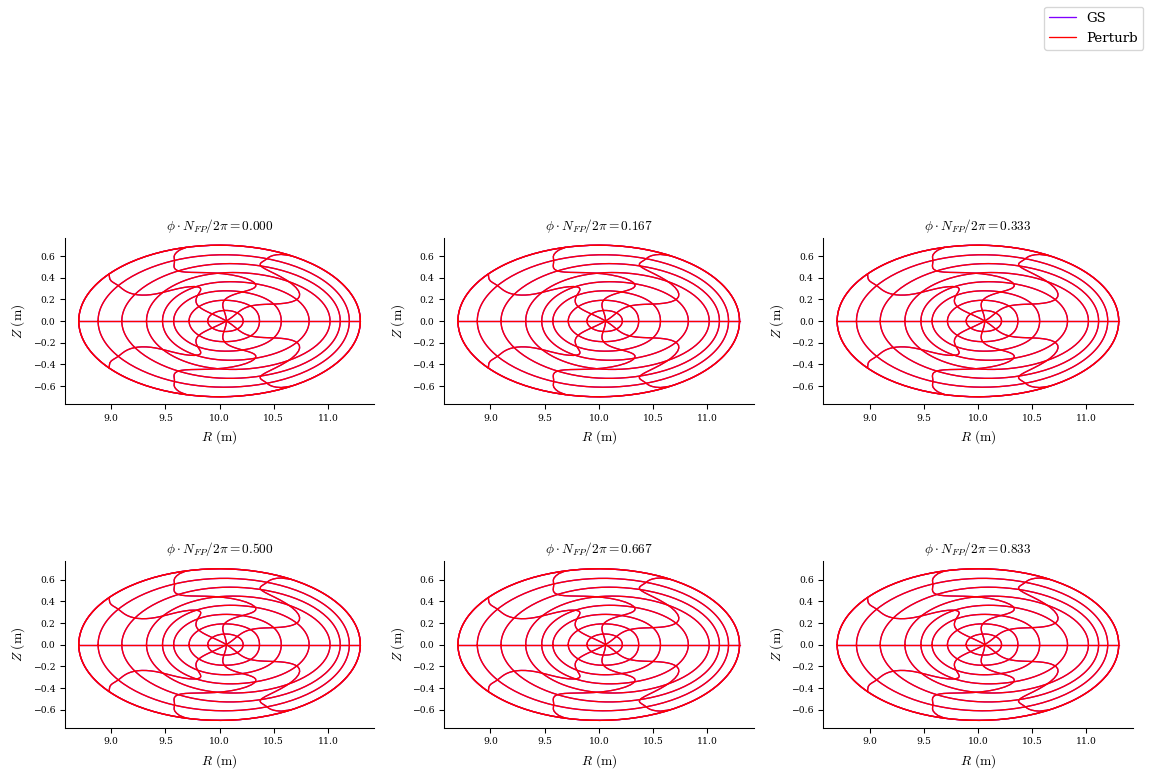

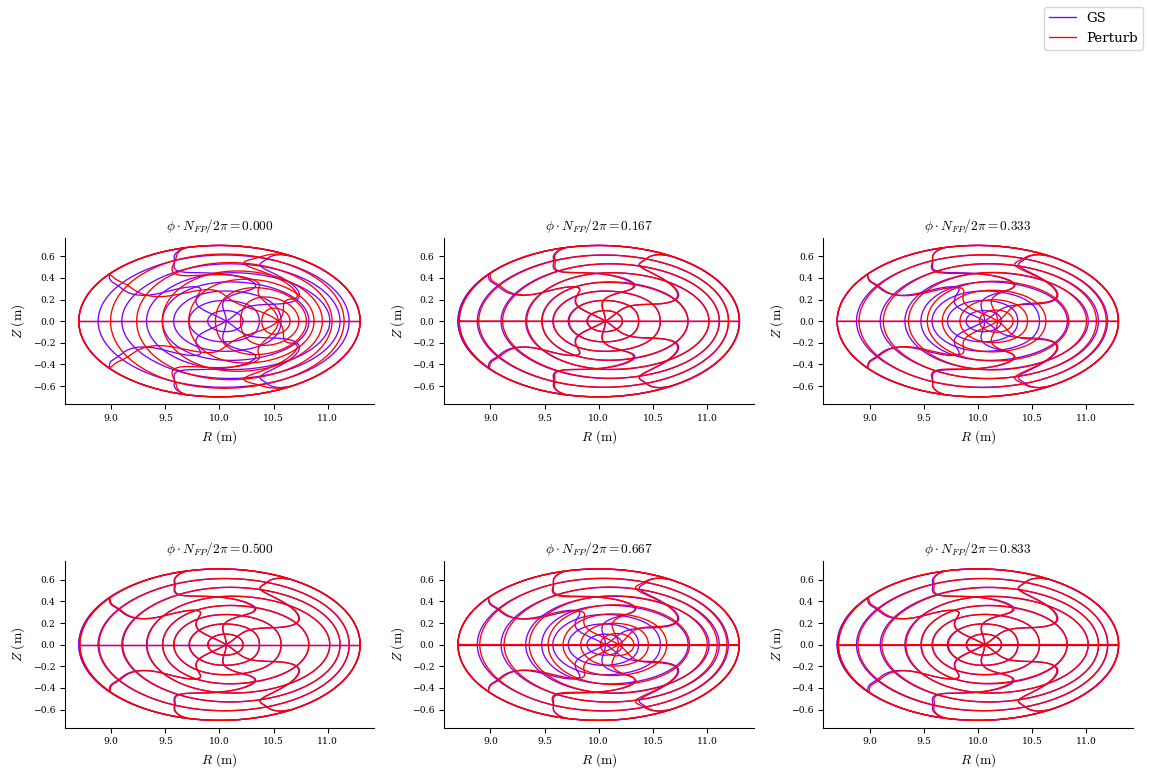

In [4]:
eq_GS_poincare = eq_GS.set_poincare_equilibrium()
eq_perturb = eq_GS_poincare.copy()
eq_perturb.change_resolution(eq.L,eq.M,eq.N)


plot_comparison(eqs=[eq_GS,eq_perturb],labels=['GS','Perturb']);

surf1 = eq_perturb.surface
surf2 = eq_poin.surface
print(surf1.L_lmn.size)
print(eq_perturb.surface.L_lmn.size)
print(eq_poin.surface.L_lmn.size)

things1 = {"surface_poincare": surf1}
things2 = {"surface_poincare": surf2}

deltas = get_deltas(things1, things2)
constraints = get_fixed_boundary_constraints(eq=eq_perturb)
objective = ObjectiveFunction(ForceBalance(eq_perturb))

eq_perturb.perturb(objective=objective, constraints=constraints, deltas=deltas, tr_ratio=0.001)

plot_comparison(eqs=[eq_GS,eq_perturb],labels=['GS','Perturb']);

# print("\nSolving after perturbation...")
# eq_perturb.solve(verbose=3, objective=objective, constraints=constraints, maxiter=50, ftol=0, xtol=0, gtol=0)

# plot_comparison(eqs=[eq,eq_GS,eq_poin,eq_perturb],labels=['Desired','GS','Poincare BC', 'Perturb']);

In [5]:
eq_GS_poincare = eq_GS.set_poincare_equilibrium()
eq_perturb = eq_GS_poincare.copy()
eq_perturb.change_resolution(eq.L,eq.M,eq.N)

surf1 = eq_perturb.surface
surf2 = eq_poin.surface
surf1 = eq_perturb.get_poincare_surface_at(zeta=0)
surf2 = eq_poin.get_poincare_surface_at(zeta=0)
print(surf1.L_lmn.size)
print(eq_perturb.surface.L_lmn.size)
print(eq_poin.surface.L_lmn.size)

114
114
114


### Solve Poincare BC using lazy Perturbation

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 137 ms
Timer: Objective build = 378 ms
Timer: Linear constraint projection build = 2.99 sec
Compiling objective function and derivatives: ['force']
Timer: Objective compilation time = 1.10 sec
Timer: Jacobian compilation time = 3.49 sec
Timer: Total compilation time = 4.60 sec
Number of parameters: 1521
Number of objectives: 4940
Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          7.909e-02                                    8.373e+00   
       1              4          9.905e-03      6.918e-02      1.387e-01      4.300e+01   
       2              5          9.559e-03      3.461e-04      1.656e-01      3.211e+01   
       3              6          1.470e-03      8.090e-03      5.074e-02      1.025e+01   
       4              8          6.837e-04      7.861e-04      3.538e-02      3.177e

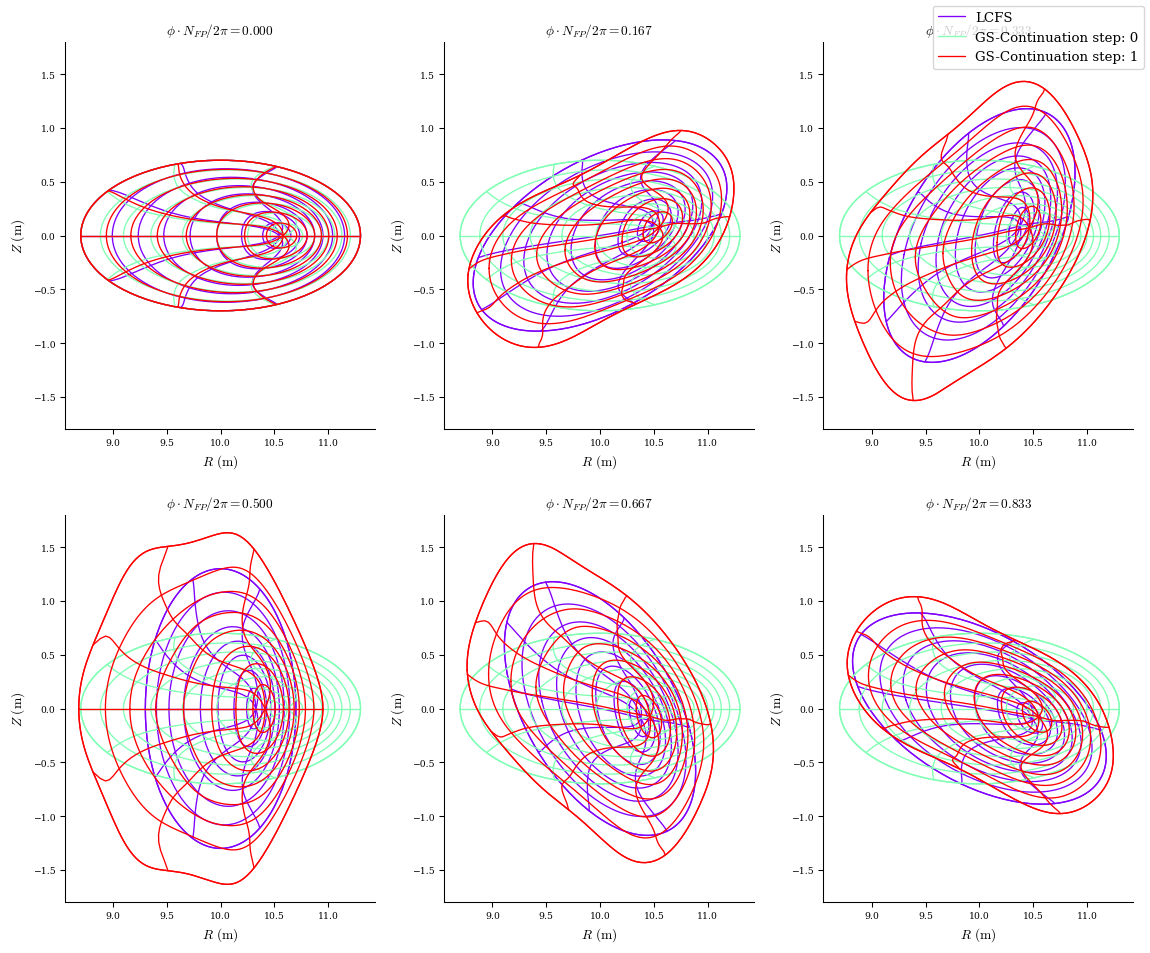

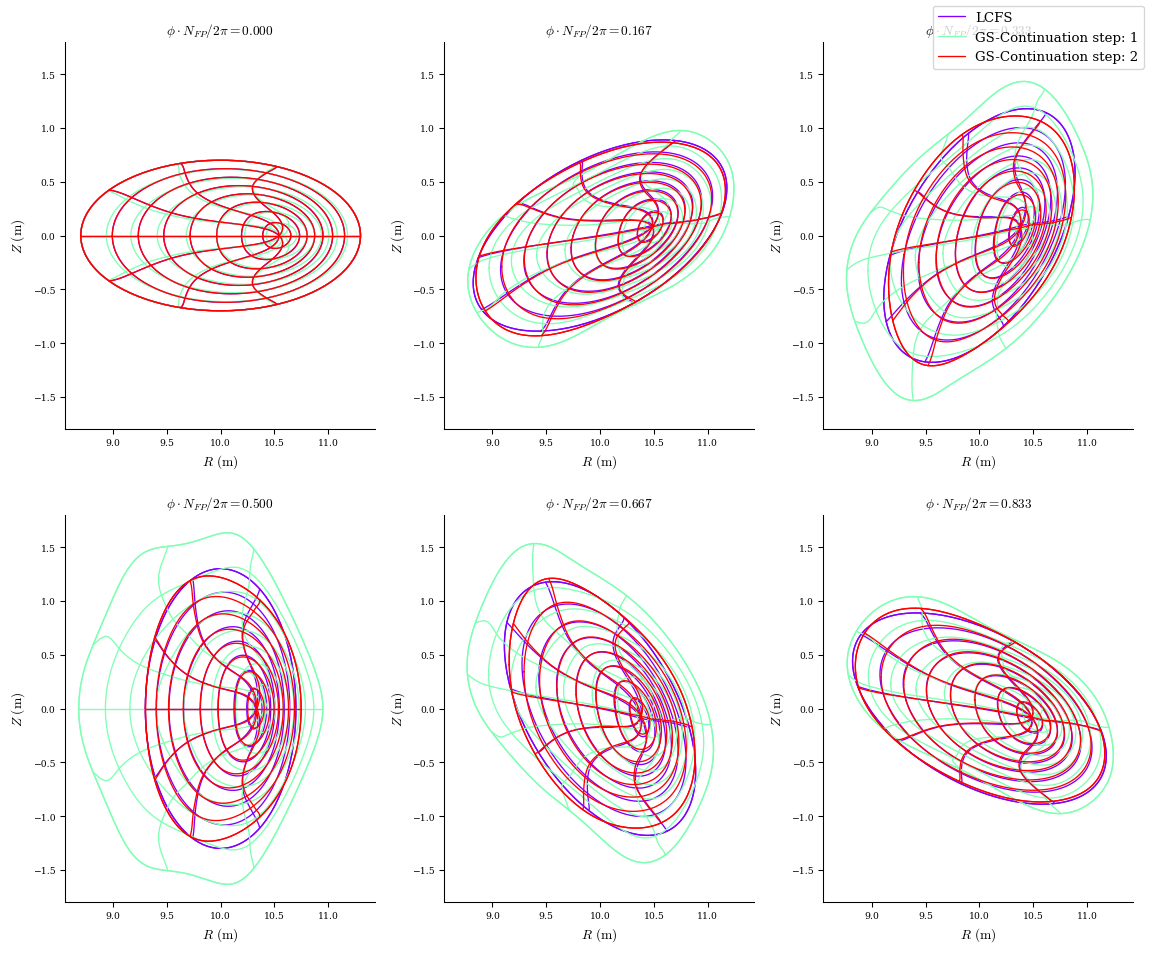

In [ ]:
NumStep = 2
maxiter = 50

eq_step = eq_GS.copy()
# print(f"{eq_poin.Lb_lmn.size=}\n{eq_poin.Lb_lmn=}")
for step in range(1,NumStep+1):
    eq_prev = eq_step.copy()
    eq_step = get_perturbed_GS_Poincare(eq=eq_step,eq_GS=eq_GS,eq_poin=eq_poin,step=step,numstep=NumStep)
    
    constraints = get_fixed_boundary_constraints(eq=eq_step)
    objective = ObjectiveFunction(ForceBalance(eq_step))

    eq_step.solve(verbose=3, objective=objective, constraints=constraints, maxiter=maxiter, ftol=0, xtol=0, gtol=0)
    # print(f"{eq_step.Lb_lmn.size=}\n{eq_step.Lb_lmn=}")
    
    plot_comparison(eqs=[eq,eq_prev,eq_step],labels=['LCFS',f'GS-Continuation step: {step-1}',f'GS-Continuation step: {step}']);